![alt text](../images/DIVE%20diagrmas.jpg "DIVE Overview")


### Library imports

In [1]:
import os, sys
script_dir = os.getcwd()
module_path = script_dir
for _ in range(5):
    module_path = os.path.abspath(os.path.join(module_path, '../'))
    if module_path not in sys.path:
        sys.path.insert(0,module_path)
    if os.path.basename(module_path).lower() =='frame':
        break
from src.unit import Unit
from src.operators import *
import src.operators
from src.operator_base import op_type_dicts
from src.system import System
import pandas as pd
from src.analye_model import *
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# print(sys.path,module_path)
from utils.display_and_plots import *
data_path = os.path.join(module_path,"data")
model_path = os.path.join(data_path,"model")

### Units.



| Item | Unit | Quantity |
|:--------:|:------------:|:-----------:|
| Memory | 'MB' | 2^20 |
| Compute | 'Tflops' | 10^9 |
| Time | 'msec' | 10^-3 |
| BandWidth | 'GBsec' | 2^30 |
| Freq | 'MHz' | 10^6 |
| Flop | 'MFLOP' | 10^6 |

### DNN Workloads

Our Current Framework supports various different workloads like CNNs, Transformers, Linear Layers.

We break each workload into operators (Individual Operations). Currently we support the following operators:
1. Convolution-2D : <span style="color:blue">Batched Activation</span> Conv <span style="color:Green">Multi Channel Multi kernal Filters</span> 
2. GEMM : <span style="color:blue">Batched Activation</span>  @ <span style="color:Red">Weights</span> 
3. Logit (Multi-Headed Attention) : <span style="color:blue">Batched Activation</span> @ <span style="color:blue">Batched Activation</span>
4. Attend (Multi-Headed Attention) : <span style="color:blue">Batched Activation</span> @ <span style="color:blue">Batched Activation</span>

In [2]:
model = 'custom'
batch_size = 4
unit = Unit()
system = System(unit, mxu_shape=[1,32,32], frequency=1000, offchip_mem_bw=100)
model_df = get_model_df(model = model, system=system, unit=unit, 
                        batch_size=batch_size, data_path=data_path, sparse=False, FLAT_enabled = False , 
                         analysis_mode="Frame" )
model_df.filter(items=['Op Type','Dimension','Op Intensity', 'Num ops (MFLOP)', 'Input_a (MB)' ,	'Input_w (MB)',	'Output (MB)',	'Total Data (MB)'])\
        .style.background_gradient(cmap='Blues',axis=0,subset=["Total Data (MB)"])\
        .background_gradient(cmap='Spectral_r',axis=1,subset=['Input_a (MB)','Input_w (MB)','Output (MB)'])\
        .background_gradient(cmap='Oranges',axis=0,subset=["Op Intensity"])


,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB)
0,CONV2D,[ 4 64 32 56 56 3 3],175.839196,429.981696,0.382812,0.017578,0.765625,1.166016
1,GEMM,[ 4 768 128 768],219.428571,603.979776,0.375000,0.562500,0.375000,1.312500
2,Logit,[ 4 8 128 128 128],42.666667,134.217728,0.500000,0.500000,0.500000,1.500000
3,Attend,[ 4 8 128 128 128],42.666667,134.217728,0.500000,0.500000,0.500000,1.500000


### System

System represents an high-level overview of the compute hardware.
Current Features Overview:
1. Compute MACs modelling.
    1. MXU shape based mapping and estimation of operators.
2. On-chip and off-chip bandwidth.
3. Sparsity in compute, memory-fetch.
4. Various quantization in memory-fetch and Compute.
5. Compute and Memory efficiency parameters to model realistic secnarios.



![alt text](../images/DIVE-compute.jpg "Dive Compute Overview")

,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Bound,Compute Cycles,Memory Cycles,C/M ratio,Cycles,% of total time,Throughput (Tflops),Latency (msec),C Effcy
0,CONV2D,[ 4 64 32 56 56 3 3],175.839196,429.981696,0.382812,0.017578,0.765625,1.166016,C,209952.000000,11386.871338,18.438076,209952.000000,33.014643,1.024000,0.419904,1.000000
1,GEMM,[ 4 768 128 768],219.428571,603.979776,0.375000,0.562500,0.375000,1.312500,C,294912.000000,12817.382812,23.008753,294912.000000,46.374478,1.024000,0.589824,1.000000
2,Logit,[ 4 8 128 128 128],42.666667,134.217728,0.500000,0.500000,0.500000,1.500000,C,65536.000000,14648.437500,4.473924,65536.000000,10.305440,1.024000,0.131072,1.000000
3,Attend,[ 4 8 128 128 128],42.666667,134.217728,0.500000,0.500000,0.500000,1.500000,C,65536.000000,14648.437500,4.473924,65536.000000,10.305440,1.024000,0.131072,1.000000


,Latency (msec),Cycles,MACs (MFLOPS),Total Data (MB),Total Weights (MB),Parameters (MB),On-chip Memory Footprint (MB)
0,1.27,635936.00,1302.40,5.48,1.58,0.58,1.50


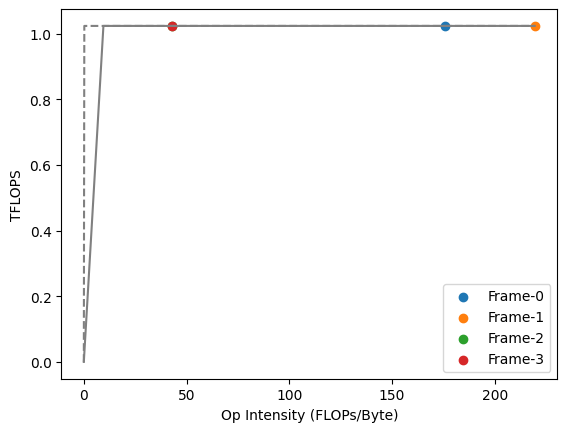

In [3]:

system = System( flops=123, mxu_shape=[1,32,32],
                 onchip_mem_bw=4000, offchip_mem_bw=100,
                 compute_efficiency=1, memory_efficiency=1,
                 frequency=500, bits='bf16')
model = 'custom'
batch_size = 4
unit = Unit()
model_df = get_model_df(model = model, system=system, unit=unit, 
                        batch_size=batch_size, data_path=data_path, sparse=False, FLAT_enabled = False , 
                         analysis_mode="Frame" )

display_df(model_df)
dot_roofline(model_df, system, unit)
get_summary_table(model_df)

,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Bound,Compute Cycles,Memory Cycles,C/M ratio,Cycles,% of total time,Throughput (Tflops),Latency (msec),C Effcy
0,CONV2D,[ 4 64 32 56 56 3 3],351.678392,429.981696,0.382812,0.017578,0.765625,1.166016,C,104976.000000,5693.435669,18.438076,104976.000000,33.014643,2.048000,0.209952,1.000000
1,GEMM,[ 4 768 128 768],438.857143,603.979776,0.375000,0.562500,0.375000,1.312500,C,147456.000000,6408.691406,23.008753,147456.000000,46.374478,2.048000,0.294912,1.000000
2,Logit,[ 4 8 128 128 128],85.333333,134.217728,0.500000,0.500000,0.500000,1.500000,C,32768.000000,7324.218750,4.473924,32768.000000,10.305440,2.048000,0.065536,1.000000
3,Attend,[ 4 8 128 128 128],85.333333,134.217728,0.500000,0.500000,0.500000,1.500000,C,32768.000000,7324.218750,4.473924,32768.000000,10.305440,2.048000,0.065536,1.000000


,Latency (msec),Cycles,MACs (MFLOPS),Total Data (MB),Total Weights (MB),Parameters (MB),On-chip Memory Footprint (MB)
0,0.64,317968.00,1302.40,5.48,1.58,0.58,1.50


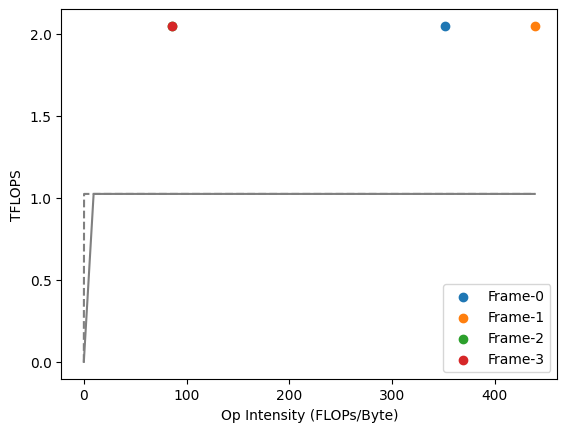

In [6]:
# Quantization

system = System( flops=123, mxu_shape=[1,32,32],
                 onchip_mem_bw=4000, offchip_mem_bw=100,
                 compute_efficiency=1, memory_efficiency=1,
                 frequency=500, bits='int8')
model = 'custom'
batch_size = 4
unit = Unit()
model_df = get_model_df(model = model, system=system, unit=unit, 
                        batch_size=batch_size, data_path=data_path, sparse=False, FLAT_enabled = False , 
                         analysis_mode="Frame" )

display_df(model_df)
dot_roofline(model_df, system, unit)
get_summary_table(model_df)

,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Bound,Compute Cycles,Memory Cycles,C/M ratio,Cycles,% of total time,Throughput (Tflops),Latency (msec),C Effcy
0,CONV2D,[ 4 64 32 56 56 3 3],175.839196,429.981696,0.382812,0.017578,0.765625,1.166016,C,209952.000000,11386.871338,18.438076,209952.000000,42.980675,1.024000,0.419904,1.000000
1,GEMM,[ 4 768 128 768],139.636364,301.989888,0.375000,0.281250,0.375000,1.031250,C,147456.000000,10070.800781,14.641934,147456.000000,30.186702,1.024000,0.294912,1.000000
2,Logit,[ 4 8 128 128 128],42.666667,134.217728,0.500000,0.500000,0.500000,1.500000,C,65536.000000,14648.437500,4.473924,65536.000000,13.416312,1.024000,0.131072,1.000000
3,Attend,[ 4 8 128 128 128],42.666667,134.217728,0.500000,0.500000,0.500000,1.500000,C,65536.000000,14648.437500,4.473924,65536.000000,13.416312,1.024000,0.131072,1.000000


,Latency (msec),Cycles,MACs (MFLOPS),Total Data (MB),Total Weights (MB),Parameters (MB),On-chip Memory Footprint (MB)
0,0.98,488480.00,1000.41,5.20,1.30,0.30,1.50


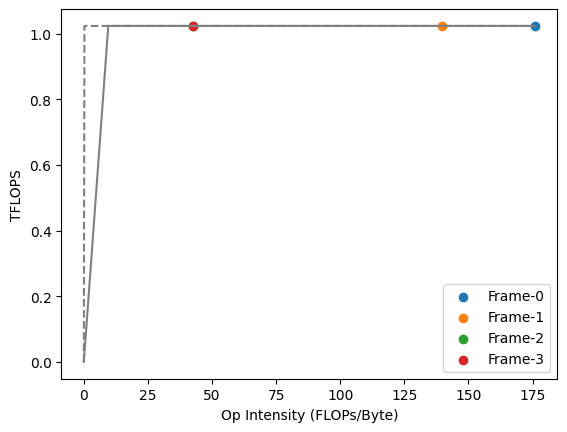

In [7]:
# Spasity

system = System(  mxu_shape=[1,32,32],
                 onchip_mem_bw=4000, offchip_mem_bw=100,
                 compute_efficiency=1, memory_efficiency=1,
                 frequency=500, bits='bf16', 
                 pe_min_density_support=0.5,accelerator_type="structured")
model = 'custom'
batch_size = 4
unit = Unit()
model_df = get_model_df(model = model, system=system, unit=unit, 
                        batch_size=batch_size, data_path=data_path, sparse=True, FLAT_enabled = False , 
                         analysis_mode="Frame" )

display_df(model_df)
dot_roofline(model_df, system, unit)
get_summary_table(model_df)

In [ ]:
# CNN-Alexnet

model = 'alexnet'

batch_size = 1
unit = Unit()
system = System(unit, mxu_shape=[1, 32,32], frequency=1000, offchip_mem_bw=100)
print(system)
model_df = get_model_df(model = model, system=system, unit=unit, 
                        batch_size=batch_size, data_path=data_path, sparse=False, FLAT_enabled = False , 
                         analysis_mode="scale-sim" )
display_df(model_df)

dot_roofline(model_df, system, unit)
get_summary_table(model_df)

Accelerator OPS: 32.768 TOPS , Freq = 1000.0 GHz, Num Cores = 1 
On-Chip mem size: inf MB , Off-chip mem size:inf MB
On-Chip mem BW: 18000.0 GB/s , Off-chip mem BW:400.0 GB/s, External-mem BW:100.0 GB/s,
Compute type: ideal , Realistic mem type: False
Sparsity Params: Acc. type: structured , Skip compute: True , Compress mem: True
******************* SCALE SIM **********************
Array Size: 	128x128
SRAM IFMAP (kB): 	10240
SRAM Filter (kB): 	10240
SRAM OFMAP (kB): 	10240
Dataflow: 	Output Stationary
CSV file path: 	./test.csv
Number of Remote Memory Banks: 	1
Bandwidth: 	400
Working in USE USER BANDWIDTH mode.

Running Layer 0


100%|██████████| 441984/441984 [05:12<00:00, 1415.63it/s]


Compute cycles: 599110
Stall cycles: 157127
Overall utilization: 65.63%
Mapping efficiency: 100.00%
Average IFMAP DRAM BW: 399.970 words/cycle
Average Filter DRAM BW: 400.000 words/cycle
Average OFMAP DRAM BW: 399.965 words/cycle

Running Layer 1


100%|██████████| 5424/5424 [00:00<00:00, 8437.22it/s]


Compute cycles: 5423
Stall cycles: 0
Overall utilization: 25.08%
Mapping efficiency: 100.00%
Average IFMAP DRAM BW: 400.000 words/cycle
Average Filter DRAM BW: 400.000 words/cycle
Average OFMAP DRAM BW: 399.610 words/cycle

Running Layer 2


100%|██████████| 3064/3064 [00:00<00:00, 8144.37it/s]


Compute cycles: 3063
Stall cycles: 0
Overall utilization: 44.40%
Mapping efficiency: 66.41%
Average IFMAP DRAM BW: 400.000 words/cycle
Average Filter DRAM BW: 400.000 words/cycle
Average OFMAP DRAM BW: 399.266 words/cycle

Running Layer 3


100%|██████████| 147328/147328 [01:06<00:00, 2216.39it/s]


Compute cycles: 147327
Stall cycles: 0
Overall utilization: 88.97%
Mapping efficiency: 100.00%
Average IFMAP DRAM BW: 400.000 words/cycle
Average Filter DRAM BW: 400.000 words/cycle
Average OFMAP DRAM BW: 399.915 words/cycle

Running Layer 4


100%|██████████| 589312/589312 [23:31<00:00, 417.51it/s]  


Compute cycles: 814161
Stall cycles: 224850
Overall utilization: 64.40%
Mapping efficiency: 100.00%
Average IFMAP DRAM BW: 399.970 words/cycle
Average Filter DRAM BW: 400.000 words/cycle
Average OFMAP DRAM BW: 399.991 words/cycle

Running Layer 5


100%|██████████| 540544/540544 [08:31<00:00, 1056.78it/s]


Compute cycles: 811875
Stall cycles: 271332
Overall utilization: 64.58%
Mapping efficiency: 100.00%
Average IFMAP DRAM BW: 399.970 words/cycle
Average Filter DRAM BW: 400.000 words/cycle
Average OFMAP DRAM BW: 399.915 words/cycle
************ SCALE SIM Run Complete ****************


,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Bound,Compute Cycles,Memory Cycles,C/M ratio,Cycles,% of total time,Throughput (Tflops),Latency (msec),C Effcy,Scale Sim Cycles,Scale Sim Thrpt (Tflops)
0,GEMM,[ 1 6144 512 2048],384.000000,12884.901888,1.000000,12.000000,3.000000,16.000000,C,393216.000000,78125.000000,5.033165,393216.000000,23.818098,32.768000,0.393216,1.000000,599110,21.506738
1,Logit,[ 1 24 512 512 85],63.812317,1069.547520,0.996094,0.996094,6.000000,7.992188,M,32640.000000,39024.353027,0.836401,39024.353027,2.363805,27.407181,0.039024,1.000000,130152,8.217680
2,Attend,[ 1 24 512 512 85],63.812317,1069.547520,6.000000,0.996094,0.996094,7.992188,M,32640.000000,39024.353027,0.836401,39024.353027,2.363805,27.407181,0.039024,1.000000,73512,14.549292
3,GEMM,[ 1 2048 512 2048],341.333333,4294.967296,1.000000,4.000000,1.000000,6.000000,C,131072.000000,29296.875000,4.473924,131072.000000,7.939366,32.768000,0.131072,1.000000,147327,29.152615
4,GEMM,[ 1 8192 512 2048],390.095238,17179.869184,1.000000,16.000000,4.000000,21.000000,C,524288.000000,102539.062500,5.113056,524288.000000,31.757463,32.768000,0.524288,1.000000,814161,21.101317
5,GEMM,[ 1 2048 512 8192],390.095238,17179.869184,4.000000,16.000000,1.000000,21.000000,C,524288.000000,102539.062500,5.113056,524288.000000,31.757463,32.768000,0.524288,1.000000,811875,21.160732


,Latency (msec),Cycles,MACs (MFLOPS),Total Data (MB),Total Weights (MB),Parameters (MB),On-chip Memory Footprint (MB)
0,1.65,1650912.71,53678.70,79.98,49.99,48.00,21.00


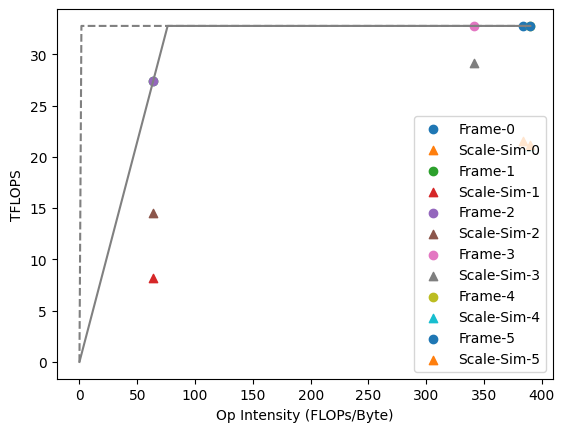

In [4]:
## Running GPT-3 1b on TPUv3 like system and comparing with scale-sim numbers.
seq_len = 512
model = 'gpt-3_1b'
data_path = os.path.join(module_path,"data")
model_path = os.path.join(data_path,"model")
model_generated = create_model(seq_len, name=model, data_path=data_path)
# print(model_path)

batch_size = 1
unit = Unit()
system = System(unit, mxu_shape=[1, 128,128], frequency=1000, offchip_mem_bw=400)
print(system)
model_df = get_model_df(model = model_generated, system=system, unit=unit, 
                        batch_size=batch_size, data_path=data_path, sparse=False, FLAT_enabled = False , 
                         analysis_mode="scale-sim" )
display_df(model_df)

dot_roofline(model_df, system, unit)
get_summary_table(model_df)

Accelerator OPS: 2.048 TOPS , Freq = 1000.0 GHz, Num Cores = 1 
On-Chip mem size: inf MB , Off-chip mem size:inf MB
On-Chip mem BW: 18000.0 GB/s , Off-chip mem BW:100.0 GB/s, External-mem BW:100.0 GB/s,
Compute type: ideal , Realistic mem type: False
Sparsity Params: Acc. type: structured , Skip compute: True , Compress mem: True
******************* SCALE SIM **********************
Array Size: 	32x32
SRAM IFMAP (kB): 	10240
SRAM Filter (kB): 	10240
SRAM OFMAP (kB): 	10240
Dataflow: 	Output Stationary
CSV file path: 	./test.csv
Number of Remote Memory Banks: 	1
Bandwidth: 	100
Working in USE USER BANDWIDTH mode.

Running Layer 0


100%|██████████| 1217200/1217200 [01:47<00:00, 11326.92it/s]


Compute cycles: 1217199
Stall cycles: 0
Overall utilization: 85.36%
Mapping efficiency: 99.94%
Average IFMAP DRAM BW: 99.998 words/cycle
Average Filter DRAM BW: 100.000 words/cycle
Average OFMAP DRAM BW: 99.998 words/cycle

Running Layer 1


100%|██████████| 169524/169524 [00:11<00:00, 14548.46it/s]


Compute cycles: 169523
Stall cycles: 0
Overall utilization: 93.62%
Mapping efficiency: 97.24%
Average IFMAP DRAM BW: 100.000 words/cycle
Average Filter DRAM BW: 100.000 words/cycle
Average OFMAP DRAM BW: 99.969 words/cycle

Running Layer 2


100%|██████████| 85920/85920 [00:05<00:00, 14590.10it/s]


Compute cycles: 85919
Stall cycles: 0
Overall utilization: 91.26%
Mapping efficiency: 94.53%
Average IFMAP DRAM BW: 100.000 words/cycle
Average Filter DRAM BW: 100.000 words/cycle
Average OFMAP DRAM BW: 99.923 words/cycle

Running Layer 3


100%|██████████| 112576/112576 [00:08<00:00, 13703.38it/s]


Compute cycles: 112575
Stall cycles: 0
Overall utilization: 92.87%
Mapping efficiency: 94.53%
Average IFMAP DRAM BW: 100.000 words/cycle
Average Filter DRAM BW: 100.000 words/cycle
Average OFMAP DRAM BW: 99.923 words/cycle

Running Layer 4


100%|██████████| 75712/75712 [00:05<00:00, 14625.12it/s]


Compute cycles: 75711
Stall cycles: 0
Overall utilization: 92.06%
Mapping efficiency: 94.53%
Average IFMAP DRAM BW: 100.000 words/cycle
Average Filter DRAM BW: 100.000 words/cycle
Average OFMAP DRAM BW: 99.923 words/cycle
************ SCALE SIM Run Complete ****************


,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Bound,Compute Cycles,Memory Cycles,C/M ratio,Cycles,% of total time,Throughput (Tflops),Latency (msec),C Effcy,Scale Sim Cycles,Scale Sim Thrpt (Tflops)
0,CONV2D,[ 1 64 3 224 224 11 11],314.305799,2127.865344,0.143555,0.022156,3.062500,3.228210,C,1099104.000000,63050.985336,17.431988,1099104.000000,72.693224,1.936000,1.099104,0.945312,1217199,1.748166
1,CONV2D,[ 1 192 64 27 27 5 5],329.082426,325.017600,0.044495,0.292969,0.133484,0.470947,C,160223.868313,9198.188782,17.419067,160223.868313,10.596986,2.028522,0.160224,0.990489,169523,1.917248
2,CONV2D,[ 1 384 192 13 13 3 3],105.520061,160.579584,0.030945,0.632812,0.061890,0.725647,C,78408.000000,14172.792435,5.532290,78408.000000,5.185797,2.048000,0.078408,1.000000,85919,1.868965
3,CONV2D,[ 1 256 384 13 13 3 3],107.819002,214.106112,0.061890,0.843750,0.041260,0.946899,C,104544.000000,18494.129181,5.652821,104544.000000,6.914396,2.048000,0.104544,1.000000,112575,1.901898
4,CONV2D,[ 1 256 256 13 13 3 3],105.520061,142.737408,0.041260,0.562500,0.041260,0.645020,C,69696.000000,12598.037720,5.532290,69696.000000,4.609597,2.048000,0.069696,1.000000,75711,1.885293


,Latency (msec),Cycles,MACs (MFLOPS),Total Data (MB),Total Weights (MB),Parameters (MB),On-chip Memory Footprint (MB)
0,1.51,1511975.87,2970.31,6.02,2.35,2.35,3.23


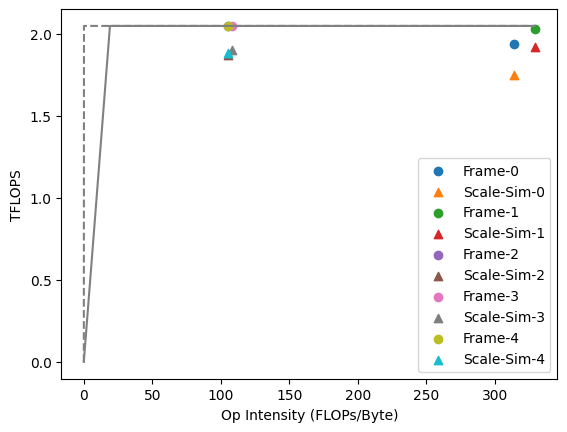

## Upcoming Features.
1. Heirarchical memory structures with optimal tiling. (In Dev.)
2. More elegant compute with different structured sparse configs.
3.